#ОБРАБОТКА РЕЗУЛЬТАТОВ ЧИСЛЕННОГО ЭКСПЕРИМЕНТА
##Магистерская диссертация

###1. Регрессионный анализ

Множественная регрессия используется для установления связи между несколькими независимыми переменными (предикторами) и зависимой переменной. 

При использовании линейной модели гиперповерхность регрессии будет расположена наиболее оптимальным способом в облаке точек в n-мерном пространстве. Однако точки (с координатами значений столбцов по выборке) чаще всего не принадлежат этой плоскости, имея некоторые отклонения. В нашем случае, будем считать мерой разброса среднеквадратичную ошибку (MSE) по выборке, т.е. сумму квадратов разностей реальных и предсказанных значений угла поворота, деленную на число выборки.
Два наиболее распространенных метода поиска коэффициентов при предикторах в модели линейной регрессии – это метод наименьших квадратов и метод градиентного спуска.
Поиск решения методом наименьших квадратов предполагает транспонирование матрицы, при этом, если определитель исходной матрицы будет близок к нулю, обратная матрица может быть ненадежна или попросту не существовать. 


Так же данный метод работает не достаточно эффективно на больших выборках, так как на обращение матрицы потребуется провести n3 операций, где n – количество позиций в выборке [17].
Градиентный спуск является общим алгоритмом и не зависит от определителя исходной матрицы признаков обучающей выборки. Применимость данного метода в нашей задаче обусловлена тем, что функция среднеквадратичной ошибки является гладкой и имеет производную в каждой точке. На первой итерации инициализируем вектор весов при объясняющих переменных (W) случайными значениями из нормального распределения со средним значением, равным нулю и дисперсией 0,01. Далее будем шагать в сторону антиградиента с заданным шагом (learning rate - μ_t) по заданному числу итераций (t) для уменьшения функционала ошибки (∇Q).





In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import copy
import collections

from google.colab import drive
drive.mount('/gdrive')
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

sets = pd.read_excel ('/gdrive/My Drive//sets.xlsx', header=0, sep='\t')
full_data = pd.read_excel ('/gdrive/My Drive//full_data.xlsx', header=0, sep='\t')
frame = pd.read_excel ('/gdrive/My Drive//real_beam_data.xlsx', header=0, sep='\t')
frame = frame.drop(['t+s beam'], axis=1)


Так как допущения при работе с регрессионными моделями не требуют строгого подчинения распределения признаков нормальному закону, на данном этапе исследования, при составлении выборки вручную, остановимся на распределениях нормального и равномерного типа.

Вначале работы исследуем скомпанованную вручную выборку параметров узлового решения

In [ ]:
sets.head()

,Beam,Column,End plate,Bolts
0,26b1,35k1,20,18
1,26b2,35k1,24,18
2,26b1,35k2,28,18
3,26b2,35k1,32,18
4,26b1,35k1,20,20


Проверим комбинации на наличие повторений:

In [ ]:
sets_data = np.array(frame.values[::]).tolist()

def CompileArray (df):
    arr = []
    for i in range (len(df)):
        s = ""
        for j in range (len(df[0])):
            if str(df[i][j]).isalnum:
                s += str(df[i][j])
            s += ' '
        arr.append(s)
    return(arr)

comb_list = list(collections.Counter(CompileArray(sets_data)).items())

def CheckRepetCombList (turpl):
    for i in range (len(turpl)):
        if turpl[i][1] == 1:
            result = "There are no repetitions!"
        if turpl[i][1] != 1:
            result = "Have a repetition in %s string!" % (i+1)
            break
    return (result)

CheckRepetCombList(comb_list)

'There are no repetitions!'

Проверим распределение элементов комбинаций на принадлежность равномерному или нормальному распередению:

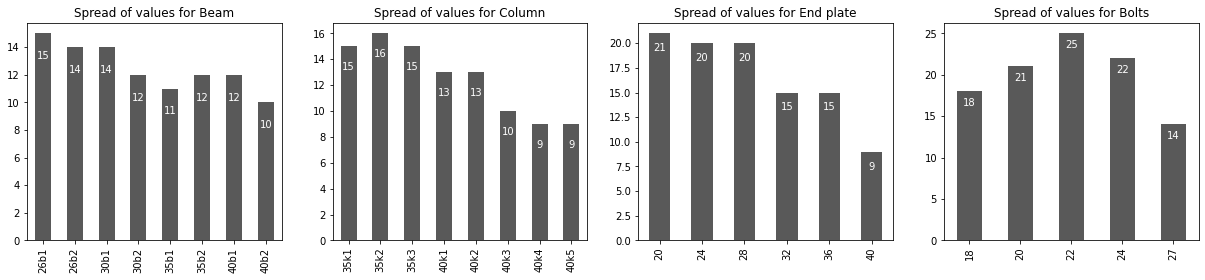

In [ ]:
def GistDistributionFeatures(df):
    plt.figure(figsize=(21,4))
    for i in range (df.shape[1]):
        plt.subplot(1, 4, i+1)
        data_to_plot = (pd.Series(df.values[:,i]).value_counts()).sort_index()
        a = data_to_plot.plot(kind = 'bar', color='black', alpha=0.65, 
                title = "Spread of values for %s"  % df.columns.tolist()[i])
        position_on_ax = a.patches
        for pos, val in zip(position_on_ax, data_to_plot):
            height = pos.get_height()
            a.text(pos.get_x() + pos.get_width() / 2, height - 2, val,
                   ha='center', va='bottom', color='white')
        #plt.savefig('Распределение %s' % df.columns.tolist()[i])
            
GistDistributionFeatures(sets)

Проверим распеределение целевого признака

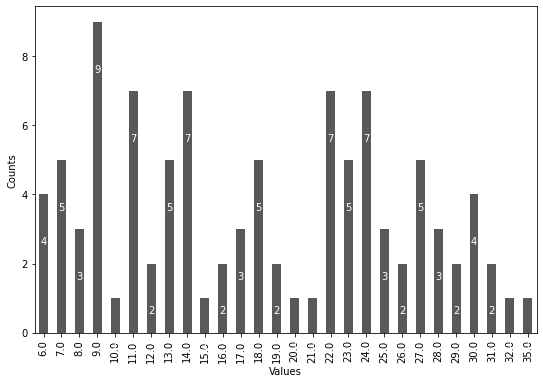

In [ ]:
def GistDistributionData(df, r=0, size=(6,6)):
    data_to_plot = (df.round(r)).value_counts().sort_index()
    plt.figure(figsize=size)
    plt.xlabel("Values")
    plt.ylabel("Counts")
    a = data_to_plot.plot(kind = 'bar', color='black', alpha=0.65)
    position_on_ax = a.patches
    for pos, val in zip(position_on_ax, data_to_plot):
        height = pos.get_height()
        a.text(pos.get_x() + pos.get_width() / 2, height - 1.5, val,
                ha='center', va='bottom', color='white')
    #plt.savefig('Распределение %s' % df.columns.tolist()[i])

GistDistributionData(frame['rot, mkrad'], size=(9,6))

По существующим рекомендациям принято учитывать в модели не более 0,05-0,1*n признаков, где n – величина выборки  [18]. Данное требование связано с тем, что соотношение количества признаков в аналитической зависимости и размера обучающей выборки влияет на обученность модели. Чем больше учитываемых признаков, тем проще отдельными их вкладами «подогнать» модель под конкретную выборку. В случае, когда качество зависимости на обучающей выборке заметно выше, чем на тестовой, можно говорить о том, что модель переобучилась. Это значит, что мы не можем рассчитывать на то, что модель окажется так же информативна на данных, которые не участвовали в выборке, как и на тех, по которым производился подбор. Переобучения можно избежать, правильно оценив и выбрав признаки, от которых будет зависеть исходная аналитическая модель. Таким образом, мы вносим некоторую логику в модель, обусловленную экспертным знанием. Так, например, мы можем оценить, какие из известных параметров балки и колонны наибольшим образом влияют на податливость соединения. Очевидно, что чем выше сечение прокатного ригеля, тем жестче он работает на изгиб. Так же можем заметить, что высота сечения колонны при использовании прокатных колонн не будет иметь большого значения, сопротивление повороту сечения балки будет осуществляться за счет толщин примыкающей полки и стенки колонны.

Мы не можем ожидать, что добавив все измеряемые параметры узлового решения, мы учтем все возможные факторы, получив тем самым наиболее точную зависимость. Следует иметь ввиду, что регрессионный анализ, особенно многомерный (учитывающий влияние более одного признака), не объясняет причинно-следственных связей между целевой переменной и объясняющими его параметрами. Мы можем интерпретировать коэффициенты при параметрах следующим образом: коэффициент показывает, насколько изменится целевая переменная при увеличении параметра при коэффициенте на единицу при условии, что все остальные параметры останутся неизменными. Если коэффициент имеет положительный знак, то зависимость прямая, при отрицательном знаке – обратная. Значение свободного коэффициента в линейных моделях показывает, чему равна целевая переменная при равенстве нулю всех остальных признаков. Чаще всего данный коэффициент не равняется нулю, далее мы убедимся, что это так и в нашем случае. При этом странно утверждать, что при нулевых значениях нагрузки и отсутствии геометрических параметров узел будет все равно иметь некоторый угол поворота. Данный метод не дает нам возможности утверждать, что вклад компонента в изменение исследуемого параметра происходит пропорционально коэффициенту в процентах, так как многие неучтенные факторы и взаимосвязь компонентов уравнения между собой в ходе регрессионного анализа закладывается в свободный коэффициент. 

С помощью регрессионного анализа мы можем только вывести математически обоснованную зависимость в виде уравнения, результат вычисления которого дает приближение к реальной величине интересующего нас параметра с той или иной степенью точности.
Отбором значимых признаков занимается отдельная ветвь машинного обучения - feature engineering, которая требует от разработчика специфических знаний в конкретной области, для которой разрабатывается модель. Для того чтобы продемонстрировать важность правильного отбора признаков, на первом этапе оставим некоторые из них, кажущиеся излишними и посмотрим на что они будут влиять.


###2. Предобработка данных

Перед началом работы с данными, необходимо проверить, соответствуют ли они ограничениям, накладываемым на возможность применения линейных моделей. Данные должны обладать следующими свойствами [19]:
1.	Линейность зависимости признаков и целевой переменной.
Конечно же, между искомым параметром и описывающими его признаками должна наблюдаться линейная связь, но это не означает, что мы ограничены только линейными функциями. Мы можем производить преобразования целевой переменной, а также переносить объясняющие признаки в спрямляющие пространства. Как правило, переход в спрямляющие пространства происходит путем логарифмирования значений признаков, если они строго больше нуля. Также можно воспользоваться добавлением к признакам их квадратов и попарных произведений для построения квадратичной зависимости. При этом следует обратить внимание на то, что увеличение количества признаков может привести к переобучению модели, а само уравнение регрессии будет иметь сложный вид с большим количеством слагаемых.

2.	Нормальность распределения остатков.
Данное свойство служит способом оценки полученной модели. Оно говорит о том, что модель с достаточной степенью точности работает на всей выборке и при должном качестве модели среднее значение остатков – разности реального и предсказываемого значения, должно стремиться к нулю и иметь график, подчиняющийся нормальному распределению.
3.	Гомогенность дисперсии остатков.
Это свойство также необходимо для оценки качества зависимости. Можно сказать, что оно некоторым образом связывает первое и второе свойство. В модели, хорошо описывающей целевой признак, остатки должны распределяться равномерно по всей выборке. Если мы видим, что в упорядоченном ряду значений целевого признака мы можем закономерно (синусоидально, параболически, логарифмически) проследить распределение остатков по их модулю и знаку, то можно сделать вывод о том, что зависимость нелинейна и необходимо вернуться к первому пункту данных требований. Если же численные преобразования над целевой переменной и описывающими признаками произведены, но при этом не выполняется требование второго свойства, можем сделать вывод, что линейные модели не могут с достаточной степенью точности описать исходные данные.
4.	Отсутствие коллинеарности предикторов.
Данное свойство связано с матричными вычислениями, при помощи которых и решаются системы линейных уравнений. Наиболее просто возникающая в ходе решения неопределенность описывается следующим примером. Пусть пара признаков нашей линейной зависимости выражается друг через друга: х1 = 2х2. Тогда, при подборе коэффициентов будет происходить следующее – при неизменных коэффициентах остальных n-2 признаков, где n – их количество в уравнении, мы можем видоизменять коэффициенты при линейно зависимых параметрах бесконечно большим количеством способов, дающих по итогу в сумме одно и то же число. Полная или частичная коллинеарность признаков делает модель неустойчивой к изменениям в выборке. Коэффициенты при зависимых параметрах могут меняться значительно при незначительных изменениях анализируемых данных. Учитывая тот факт, что мы пытаемся вывести аналитическую формулу, применимую для практических расчетов, мы не можем использовать неустойчивые модели. Поэтому необходимо исследовать признаки на коллинеарность и при необходимости производить с ними некоторые преобразования.
Нормальность распределения остатков произведем для наиболее точной модели для того, чтобы оценить, достаточно ли хорошо линейная модель подходит для описания данных.


***Мультиколлинеарность***

Зависимость строк или столбцов матрицы приводит к ее вырождению, а, следовательно, невозможности производить матричные умножения для определения оптимальных параметров вектора весов при решении уравнений [21]. Так же, если посмотреть на таблицу корреляции признаков, можно заметить, что коэффициент корреляции некоторых их них близок к единице, что говорит о том, что в данных признаках присутствует зависимость одного и того же вида, что по сути дает возможность объединить их в один признак с общим коэффициентом. Наличие коррелирующих признаков влияет на статистическую значимость других признаков выборки, таким образом, мы можем пропустить какой-то из важных параметров общего уравнения. Мультиколлинеарность влияет на устойчивость модели, т.е. при незначительных изменениях выборки, коэффициенты при предикторах могут менять свои значения в большом диапазоне [22]. Воспользуемся методом .corr() из стандартных инструментов Python 3.7.
Коэффициент корреляции рассчитывается по формуле Пирсона:


Проверим признаки на мультиколлинеарность:

In [ ]:
full_data.corr().round(3)

,t beam,s beam,h beam,t column,s column,t end plate,d bolts,"rot, mkrad"
t beam,1.000,0.707,0.445,0.136,0.149,0.447,0.119,-0.300
s beam,0.707,1.000,0.898,0.413,0.427,0.462,0.285,-0.699
h beam,0.445,0.898,1.000,0.515,0.527,0.426,0.331,-0.859
t column,0.136,0.413,0.515,1.000,0.999,0.132,0.231,-0.795
s column,0.149,0.427,0.527,0.999,1.000,0.142,0.237,-0.801
t end plate,0.447,0.462,0.426,0.132,0.142,1.000,0.196,-0.293
d bolts,0.119,0.285,0.331,0.231,0.237,0.196,1.000,-0.376
"rot, mkrad",-0.300,-0.699,-0.859,-0.795,-0.801,-0.293,-0.376,1.000


Заменим коррелирующие признаки параметров колонны на их сумму, для балки оставим параметр ее высоты, проверим корреляцию снова:

In [ ]:
frame.corr().round(3)

,t+s column,t+s beam,h beam,Bolts,End plate,"rot, mkrad"
t+s column,1.000,0.262,0.520,0.234,0.136,-0.768
t+s beam,0.262,1.000,0.658,0.194,0.487,-0.526
h beam,0.520,0.658,1.000,0.331,0.426,-0.867
Bolts,0.234,0.194,0.331,1.000,0.196,-0.357
End plate,0.136,0.487,0.426,0.196,1.000,-0.396
"rot, mkrad",-0.768,-0.526,-0.867,-0.357,-0.396,1.000


Выведем графики зависимости угла поворота от скорректированного набора признаков:

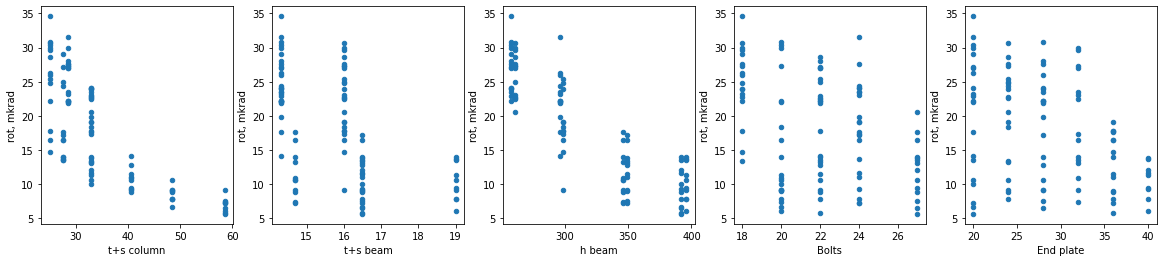

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for idx, feature in enumerate(frame.columns[:-1]):
    frame.plot(feature, "rot, mkrad", subplots=True, kind="scatter", ax=axes[int(idx % 5)])

Заметим некоторую закономерность изменчивости угла поворота относительно параметров колонны и высоты балки.

Присвоим значения переменных:

Х - предикторы (признаки), 

Y - зависимая величина (угол поворота).

In [ ]:
Y = frame.values[:,(frame.shape[1] - 1):]
X = frame.values[:, :-1]

***Линейность зависимости признаков***

Используя линейные модели при выводе аналитической формулы, очевидно, что мы ожидаем линейной зависимости между признаками и целевой переменной. Исследуем наши данные на линейность, запустив модель поиска решения. 


Построим простую модель линейной регрессии с помощью модуля LinearRegression библиотеки Sklearn:

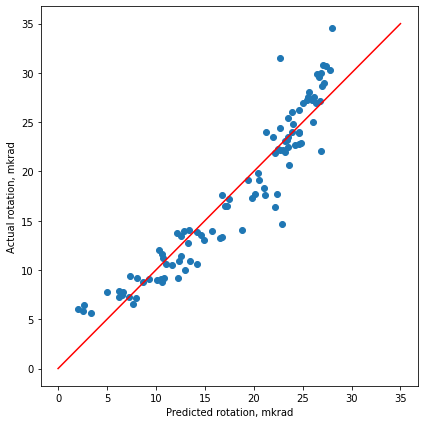

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, Y)
pred = regressor.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(pred, Y)
plt.xlabel('Predicted rotation, mkrad')
plt.ylabel('Actual rotation, mkrad')
plt.plot([0., 35], [0., 35], color="red")
plt.tight_layout()


Точки на рисунке имеют координату по оси абсцисс, соответствующую значению угла поворота, посчитанному с помощью метода наименьших квадратов (МНК). Ординатами точек являются углы поворота, полученные численным методом расчета в Femap. Биссектриса квадранта в упрощенном виде представляет собой регрессионную прямую. Если модель со стопроцентной точностью будет описывать характер распределения зависимого признака, все точки лягут на прямую – реальное значение будет соответствовать предсказанному аналитической моделью, координаты точек по оси х и у будут равны.
Как мы можем заметить, признаки в явно выраженном виде имеют нелинейную зависимость от целевой переменной. Визуально оценив разброс отклонений, видим, что их распределение по выборке неравномерно. Такие модели обладают свойством гетероскедастичности, т.е. отсутствием постоянства дисперсии случайной ошибки. Попробуем снизить данное влияние. Существует несколько подходов:
1.	Использование взвешенного метода наименьших квадратов;
2.	Замена исходных данных логарифмом или другой нелинейной функцией;
3.	Определение областей, внутри которых дисперсия ошибки относительно стабильна.


Как мы можем заметить, характер зависимости нелинейный. Далее по ходу работы определим функцию, наиболее подходящую для описания совокупности признаков.

При нахождении решения линейного уравнения с использованием градиентных методов, следует отметить, что последние чувствительны к масштабированию анализируемых признаков. В соответствии с допущениями, принятыми при работе с линейными моделями [20], стандартизируем наши данные, т.е. вычтем среднее значение по каждому из признаков и поделим на стандартное отклонение их исходные значения. По итогу будем иметь распределение признаков со стандартным отклонением, равным нулю, и дисперсией, равной единице. Без начальной стандартизации данных мы не сможем двигаться дальше, так как функция минимализации среднеквадратичной ошибки в нашей модели не сойдется к своему минимуму.

Стандартизируем признаки:

In [ ]:
X_for_norm = pd.DataFrame(X[:,:])
X_norm = (X_for_norm - X_for_norm.mean()) / X_for_norm.std()
print (X_norm.head())

          0         1         2         3
0 -0.180241 -1.199585  0.000000 -1.298336
1 -0.629596 -0.454014 -0.699206 -1.298336
2  2.366103  1.429535  1.748015 -0.061826
3 -0.979094 -0.395153 -1.398412 -0.680081
4 -0.180241 -0.395153 -1.398412  1.174685


Разобьем выборку на обучающую и тестовую.

На первой подберем коэффициенты, на второй - проверим их.
Делим в соотношении 80/20.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size = 0.2)
X_train.columns = frame.drop(['rot, mkrad'], axis=1).columns
X_test.columns = X_train.columns

Класс для линейной регрессии с градиентным спуском:

In [ ]:
class LinearRegres:

    def __init__(self, mae_metric=False):
        """
            @param mae_metrics: В случае True необходимо следить за
            метрикой MAE во время обучения, иначе - за метрикой MSE
        """
        self.metric = self.calc_mse_metric if not mae_metric else self.calc_mae_metric
    
    def calc_mae_metric(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mae: значение MAE
        """
        mae = (abs(y - preds)).sum() / len(preds)
        return mae
    
    def calc_mse_metric(self, preds, y):
        """
            @param preds: предсказания модели
            @param y: истиные значения
            @return mse: значение MSE
        """
        mse = ((y - preds)**2).sum() / len(preds)
        return mse
    
    def init_weights(self, input_size, output_size):
        """
            Инициализирует параметры модели
            W - матрица размерности (input_size, output_size)
            инициализируется рандомными числами из
            нормального распределения (np.random.normal)
            со средним 0 и стандартным отклонением 0.01
            b - вектор размерности (1, output_size)
            инициализируется нулями
        """
        np.random.seed(42)
        self.W = np.random.normal(loc=0.0, scale=0.01, size=(input_size, output_size))
        self.b = np.zeros((1, output_size), dtype = float)

    def fit(self, X, y, num_epochs=1000, lr=0.001):
        """
            Обучение модели линейной регрессии методом градиентного спуска
            @param X: размерности (num_samples, input_shape)
            @param y: размерности (num_samples, output_shape)
            @param num_epochs: количество итераций градиентного спуска
            @param lr: шаг градиентного спуска
            @return metrics: вектор значений метрики на каждом шаге градиентного
            спуска. В случае mae_metric==True вычисляется метрика MAE
            иначе MSE
            https://www.coursera.org/lecture/supervised-learning/gradiientnyi-spusk-dlia-linieinoi-rieghriessii-adARX
        """
        self.init_weights(X.shape[1], y.shape[1])
        metrics = []
        for _ in range(num_epochs):
            preds = self.predict(X)
            coef = 2/X.shape[0]
            b_grad = np.mean(2*(X @ self.W + self.b - y), axis=0)
            W_grad = np.array(coef*X.T @ (X @ self.W + self.b - y))
            metrics.append(self.metric(preds, y))
            self.W -= lr*W_grad   
            self.b -= lr*b_grad
        return metrics

    def predict(self, X):
        y_pred = X @ self.W + self.b
        return y_pred

    def coefs (self, set_fiture=X_for_norm, fr=frame):
      coefs = pd.DataFrame({'index': fr.columns.drop('rot, mkrad'),
                            'values': (self.W.reshape(-1) / X_for_norm.std()).round(4)})
      coefs.loc[len(coefs)] = ['free coef', round(float(self.b.reshape(-1) -
                                          (self.W.reshape(-1) * X_for_norm.mean()
                                          / X_for_norm.std()).sum()), 4)]

      return coefs

In [ ]:
model = LinearRegres()

def CheckResultLR(X, y, name, grade, print_pred_act=True, print_diff_mse=True, print_graph=True):
    df_pred_act = model.predict(X)**grade
    df_pred_act.columns = ['PRED ROT']
    df_pred_act['ACT ROT'] = y
    if (print_pred_act == True):
        print(df_pred_act.round(2))

    diff = df_pred_act['ACT ROT'] - df_pred_act['PRED ROT']
    mse_test = (diff**2).sum() / len(y)
    if (print_diff_mse == True):
        print ('%s MSE:      ' % name,  mse_test.round(4))
        print ('%s MAX DIFF: ' % name, max(abs(diff).round(4)))

    if (print_graph == True):
        plt.figure(figsize=(6, 6))
        plt.scatter(df_pred_act['PRED ROT'], df_pred_act['ACT ROT'])
        plt.xlabel('Predicted rotation, mkrad')
        plt.ylabel('Actual rotation, mkrad')
        plt.plot([0., 0.350], [0., 0.350], color="red")
        plt.tight_layout()

def MseResult(label, grade, X=X_train, Y=Y_train):
    y = copy.deepcopy(Y)
    y **= (1/grade)
    mse = model.fit(X, y, num_epochs=1000, lr=0.01)

Для функции кубической параболы посчитаем модель и построим график функции среднеквадратичной ошибки (MSE), убедимся в том, что он строго убывает.

MSE last iteration:  0    0.010631
dtype: float64
        index  values
0  t+s column -0.0209
1      h beam -0.0043
2       Bolts -0.0010
3   End plate -0.0047
4   free coef  4.8104
5.845


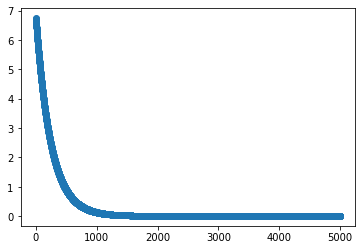

In [ ]:
exp = 3
mse = model.fit(X_train, Y_train**(1/exp), num_epochs=5000, lr=0.001)
plt.scatter(range(len(mse)), mse)
print ("MSE last iteration: ", mse[len(mse)-1])

Выведем коэффициенты регрессии:

In [ ]:
coefs_grad = model.coefs()
coefs_grad

,index,values
0,t+s column,-0.0209
1,h beam,-0.0043
2,Bolts,-0.0010
3,End plate,-0.0047
4,free coef,4.8104


Проверим полученных коэффициенты на тестовой выборке:

In [ ]:
out_data = frame.loc[X_test.index.tolist()].round(4)
out_data['pred rot, mkrad'] = (model.predict(X_test)**exp).round(4)
out_data['diff, mkrad'] = (out_data['rot, mkrad'] - out_data['pred rot, mkrad']).round(4)
out_data['error, %'] = abs((out_data['diff, mkrad'] / out_data['rot, mkrad'])*100).round(1)
out_data['C0, kNm/rad'] = (10**6/out_data['pred rot, mkrad']).round(1)
out_data

,t+s column,h beam,Bolts,End plate,"rot, mkrad","pred rot, mkrad","diff, mkrad","error, %","C0, kNm/rad"
93,58.5,349,24,36,7.262,6.7791,0.4829,6.6,147512.2
15,28.5,296,18,20,23.153,22.6572,0.4958,2.1,44136.1
30,33.0,258,24,32,23.528,22.8173,0.7107,3.0,43826.4
17,40.5,349,24,36,10.959,11.6894,-0.7304,6.7,85547.6
81,33.0,296,24,28,19.826,19.5045,0.3215,1.6,51270.2
86,48.5,346,27,24,8.809,10.1922,-1.3832,15.7,98114.2
69,58.5,349,27,28,7.442,7.1567,0.2853,3.8,139729.2
48,28.5,261,18,32,27.240,24.9928,2.2472,8.2,40011.5
20,25.0,296,18,28,26.022,23.5267,2.4953,9.6,42504.9
45,33.0,346,22,24,13.277,15.5834,-2.3064,17.4,64170.8


Посчитаем среднюю ошибку на тесте:

In [ ]:
round(out_data['error, %']. mean(), 3)

5.845

Оценим распределение остатков и их среднее значение:

Diff mean test:  0.3324
Diff mean all:   0.1521
R2_adj score:     0.922


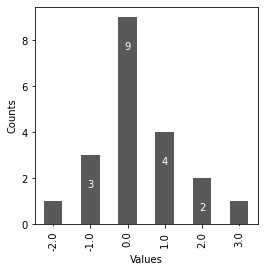

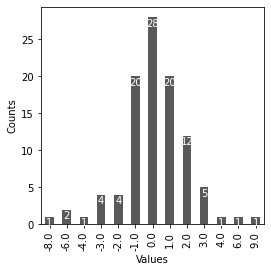

In [ ]:
y_pred = model.predict(X_norm)**exp
diff_all = (Y - y_pred)

GistDistributionData(out_data['diff, mkrad'], r=0, size=(4,4))
GistDistributionData(diff_all[0], r=0, size=(4,4))
print ("Diff mean test: ", round(out_data['diff, mkrad'].mean(), 4))
print ("Diff mean all:  ", round(float(diff_all.mean()), 4))
r2 = r2_score(out_data['rot, mkrad'], out_data['pred rot, mkrad'])
r2_adj = 1 - (1 - r2_score(Y, y_pred))*(len(Y)-1)/(len(Y) - len(X[0]))
print ("R2_adj score:    ", round(r2_adj, 3))

Отметим, что выполняется требование к нормальности распределения остатков и равенства их среднего значения по всей выборке нулю (0,15). А так же значение скорректированного коэффициента детерминации R2adj = 0.922 свидетельствует о том, что 92% данных объясняются полученной зависимостью.

Исследуем, как ведет себя модель на всей выборке. Отобразим распределение остатков на графике. Для этого отсортируем значения углов поворота в нашей выборке по возрастанию. По оси абсцисс отметим порядковые номера элементов отсортированной выборки от 1 до 100. Выше оси абсцисс отобразим гистограмму величин реальных углов поворота. Ниже оси абсцисс под каждым элементом отложим соответствующее значение модуля разницы реального угла поворота и рассчитанного по формуле в масштабе 5:1. Красным цветом обозначены величины, отличающиеся от среднего значения на величину, большую стандартного отклонения. Если на каком-либо из элементов выборки цвет обоих частей гистограммы красный, это означает, что данный имеет достаточно большое отклонение от среднего значения по обоим из показателей. Ошибка на таких элементах во многом зависит не от качества модели, а от того, что конкретный случай наиболее выражено отклоняется от нормального распределения по модели.

In [ ]:
Y_pred = model.predict(X_norm)**exp
Y_act = frame['rot, mkrad']
Diff = Y_act - Y_pred[0]
Per_er = abs(Diff / Y_act)

def get_color_gists(Y, mark_type=0, main_color='k', direction=1, scale=1):
  for pos, val in zip(Y.index, Y):
    if (abs(val - Y.mean()) < Y.std() 
        or ((Y.mean() - val) > Y.std() and mark_type == 1) 
        or (mark_type == 2)):
      plt.bar(pos, direction*scale*val, color=main_color, alpha=0.25)
    else:
      plt.bar(pos, direction*scale*val, color='r', alpha=0.25)

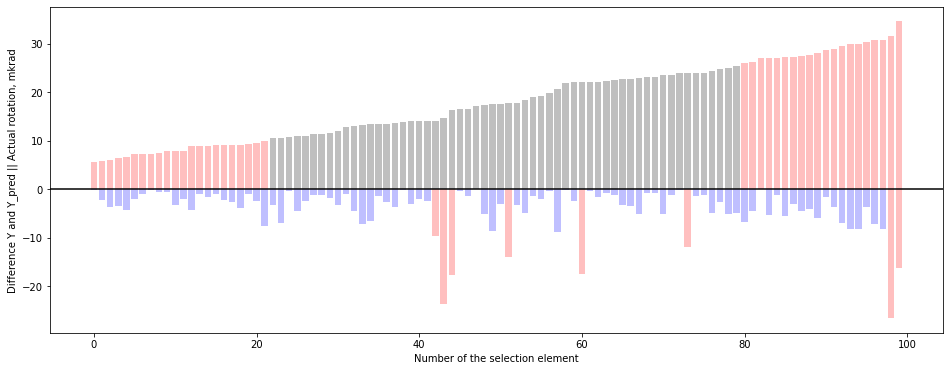

In [ ]:
df_Y = pd.DataFrame({'Y': Y_act,
                    'Diff': Diff,
                    'Per_er': Per_er})

def sort_and_out_one_param(df_input, name_param, name_out_param):
  df_input.sort_values([name_param], axis=0, ascending=True, inplace=True)
  df = df_input[name_out_param].reset_index().drop(['index'], axis=1)
  return (df)

Y_sort = sort_and_out_one_param(df_Y, 'Y', 'Y')
diff_sort = sort_and_out_one_param(df_Y, 'Y', 'Diff')
per_er_sort = sort_and_out_one_param(df_Y, 'Y', 'Per_er')

plt.figure(figsize=(16, 6))
ax = plt.gca()
ax.axhline(y=0, color='k')
plt.xlabel('Number of the selection element')
plt.ylabel('Difference Y and Y_pred || Actual rotation, mkrad')

get_color_gists(Y_sort['Y'])
get_color_gists(abs(diff_sort['Diff']), mark_type=1, main_color='b', direction=-1, scale=3)
#get_color_gists(per_er_sort['Per_er'], mark_type=2, main_color='b', direction=-1, scale=50)

Данное выбросы в распределении остатков могут быть связаны с тем, что распределение величины угла поворота по выборке не подчиняется нормальному закону, что невозможно проконтролировать до того, как будет произведен расчет всех численных моделей. Так как экспериментальная выборка и так была довольно небольшой, не было возможности взять из нее достаточно большую подвыборку с нормальным распределением целевой переменной.

Для оценки устойчивости модели произведем расчет библиотечным методом наименьших квадратов, а так же изменим размер выборки в модели градиентного спуска:

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, Y_train**(1/exp))
coefs_ols = pd.DataFrame({'index': frame.columns.drop('rot, mkrad'),
                      'values': (regressor.coef_.reshape(-1) / X_for_norm.std()).round(4)})
coefs_ols.loc[len(coefs_ols)] = ['free coef', round(float(regressor.intercept_ -
                                    (regressor.coef_.reshape(-1) * X_for_norm.mean()
                                    / X_for_norm.std()).sum()), 4)]
# predict_ols = regressor.predict(X_test)**exp
# mse_ols = ((Y_test - predict_ols)**2).sum() / len(Y_test)
# print ("MSE: ", round(mse_ols, 2))
coefs_ols

,index,values
0,t+s column,-0.0206
1,h beam,-0.0044
2,Bolts,-0.0018
3,End plate,-0.0045
4,free coef,4.8505


In [ ]:
test_size_arr = [0.10, 0.15, 0.25]

for i in range (len(test_size_arr)): 
    X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size = test_size_arr[i])
    mse = model.fit(X_train, Y_train**(1/exp), num_epochs=1000, lr=0.01)
    coefs = model.coefs()
    print ('TEST %s:' % str(i+1))
    print (coefs, '\n')

TEST 1:
        index  values
0  t+s column -0.0212
1      h beam -0.0045
2       Bolts -0.0023
3   End plate -0.0037
4   free coef  4.8771 

TEST 2:
        index  values
0  t+s column -0.0209
1      h beam -0.0045
2       Bolts -0.0017
3   End plate -0.0037
4   free coef  4.8515 

TEST 3:
        index  values
0  t+s column -0.0213
1      h beam -0.0042
2       Bolts -0.0023
3   End plate -0.0043
4   free coef  4.8161 



Как мы можем заметить, коэффициенты изменяются крайне незначительно, что говорит о том, что модель устойчива к изменениям в обучающей выборке, следовательно, достаточно точно отражает зависимость между предикторами и целевой переменной по всей выборке.

##Список источников

17.	 Соколов, Е.В. Обучение линейной регрессии [Электронный ресурс]. – Режим доступа: https://www.coursera.org/learn/supervised-learning/lecture/hCGR6/obuchieniie-linieinoi-rieghriessii, требуется авторизация – (24.05.2020).
18.	 Статистика. Множественная регрессия  [Электронный ресурс]. – Режим доступа: http://statsoft.ru/home/textbook/modules/stmulreg.html#alimitations, свободный – (24.05.2020).
19.	 Карпов, А.Д. Корреляция и регрессия [Электронный ресурс]. – Режим доступа:  https://www.stepik.org/lesson/8090/step/3?unit=1369, требуется авторизация  – (24.05.2020).
20.	 Диагностика линейных регрессионных моделей [Электронный ресурс]. – Режим доступа: https://r-analytics.blogspot.com/2014/09/1.html, свободный – (24.05.2020).
21.	 Нейчев, Р.Г. Основы машинного обучения (лекция 12.10.2019) [Электронный ресурс]. – Режим доступа: https://youtu.be/Gk_lr5xDXLU?t=2095, свободный (24.05.2020).
22.	 Хайтов, В.М. Множественная линейная регрессия [Электронный ресурс]. – Режим доступа: https://www.coursera.org/learn/lineynaya-regressiya/lecture/8j5kY/mul-tikolliniearnost-i-drughiie-usloviia-primienimosti, требуется авторизация – (24.05.2020).
